# Model Training and Evaluation

This notebook covers the machine learning model training process for the AI-enhanced 60/40 portfolio strategy.

## Objectives:
1. Engineer features from economic indicators
2. Train decision tree models for each asset
3. Evaluate model performance
4. Analyze feature importance
5. Validate with cross-validation

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from sklearn.tree import plot_tree
import warnings
warnings.filterwarnings('ignore')
from data_acquisition import DataAcquisition
from feature_engineering import FeatureEngineer
from ml_model import PortfolioMLModel
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

## 1. Load Data and Configuration

In [3]:
# Load configuration
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Fetch data
data_acq = DataAcquisition(config)
prices, returns, indicators = data_acq.get_full_dataset()

print(f"Data loaded: {len(prices)} periods from {prices.index[0]} to {prices.index[-1]}")

Fetching asset prices...
Fetched prices for 4 assets from 2017-01-01 00:00:00 to 2024-12-30 00:00:00
Fetching VIX data...
Fetching yield spread data...
Fetching interest rate data...

Indicators summary:
             VIX  Yield_Spread  Interest_Rate
count  2922.0000     2922.0000      2922.0000
mean     18.6570        0.4484         2.1637
std       7.6876        0.9770         1.9075
min       9.1400       -1.7040         0.0400
25%      13.2225       -0.2868         0.2700
50%      16.8800        0.5650         1.6900
75%      21.8800        1.2457         4.3300
max      82.6900        2.3080         5.3300
Data loaded: 96 periods from 2017-01-31 00:00:00 to 2024-12-31 00:00:00


## 2. Feature Engineering

In [5]:
# Initialize feature engineer
feature_eng = FeatureEngineer(config)

# Create all features
print("Engineering features...")
features_raw = feature_eng.engineer_all_features(indicators)
print(f"Raw features created: {features_raw.shape}")

# Prepare features for training
features = feature_eng.prepare_features_for_training(features_raw)
print(f"Prepared features: {features.shape}")
print(f"Feature columns: {len(features.columns)}")

Engineering features...
Raw features created: (96, 67)
Prepared features: (85, 67)
Feature columns: 67


In [6]:
# Inspect indicators DataFrame
print(f"Indicators shape: {indicators.shape}")
print(f"Indicators date range: {indicators.index.min()} to {indicators.index.max()}")
print(f"Indicators frequency (first 5 dates): {indicators.index[:5].tolist()}")
print(f"Indicators missing values per column:\n{indicators.isnull().sum()}")

# Inspect how many rows are dropped after feature engineering
print(f"Rows in features_raw: {features_raw.shape[0]}")
print(f"Rows in features after preparation: {features.shape[0]}")
print(f"Rows dropped during preparation: {features_raw.shape[0] - features.shape[0]}")
print(f"Missing values in features_raw per column:\n{features_raw.isnull().sum()}")
print(f"Missing values in features per column:\n{features.isnull().sum()}")

Indicators shape: (96, 3)
Indicators date range: 2017-01-31 00:00:00 to 2024-12-31 00:00:00
Indicators frequency (first 5 dates): [Timestamp('2017-01-31 00:00:00'), Timestamp('2017-02-28 00:00:00'), Timestamp('2017-03-31 00:00:00'), Timestamp('2017-04-30 00:00:00'), Timestamp('2017-05-31 00:00:00')]
Indicators missing values per column:
VIX              0
Yield_Spread     0
Interest_Rate    0
dtype: int64
Rows in features_raw: 96
Rows in features after preparation: 85
Rows dropped during preparation: 11
Missing values in features_raw per column:
VIX               0
Yield_Spread      0
Interest_Rate     0
VIX_ma_3          2
VIX_std_3         2
                 ..
vix_percentile    0
inverted_curve    0
flat_curve        0
steep_curve       0
high_rate         0
Length: 67, dtype: int64
Missing values in features per column:
VIX               0
Yield_Spread      0
Interest_Rate     0
VIX_ma_3          0
VIX_std_3         0
                 ..
vix_percentile    0
inverted_curve    0
flat

In [7]:
# Display sample features
print("Sample of engineered features:")
display(features.head())

print("\nFeature columns:")
for i, col in enumerate(features.columns, 1):
    print(f"{i:3d}. {col}")

Sample of engineered features:


,VIX,Yield_Spread,Interest_Rate,VIX_ma_3,VIX_std_3,VIX_min_3,VIX_max_3,VIX_ma_6,VIX_std_6,VIX_min_6,VIX_max_6,VIX_ma_12,VIX_std_12,VIX_min_12,VIX_max_12,Yield_Spread_ma_3,Yield_Spread_std_3,Yield_Spread_min_3,Yield_Spread_max_3,Yield_Spread_ma_6,Yield_Spread_std_6,Yield_Spread_min_6,Yield_Spread_max_6,Yield_Spread_ma_12,Yield_Spread_std_12,Yield_Spread_min_12,Yield_Spread_max_12,Interest_Rate_ma_3,Interest_Rate_std_3,Interest_Rate_min_3,Interest_Rate_max_3,Interest_Rate_ma_6,Interest_Rate_std_6,Interest_Rate_min_6,Interest_Rate_max_6,Interest_Rate_ma_12,Interest_Rate_std_12,Interest_Rate_min_12,Interest_Rate_max_12,VIX_change_1m,VIX_change_3m,VIX_change_6m,VIX_pct_change_1m,VIX_pct_change_3m,VIX_pct_change_6m,Yield_Spread_change_1m,Yield_Spread_change_3m,Yield_Spread_change_6m,Yield_Spread_pct_change_1m,Yield_Spread_pct_change_3m,Yield_Spread_pct_change_6m,Interest_Rate_change_1m,Interest_Rate_change_3m,Interest_Rate_change_6m,Interest_Rate_pct_change_1m,Interest_Rate_pct_change_3m,Interest_Rate_pct_change_6m,VIX_x_Spread,VIX_div_Spread,Rate_x_VIX,Rate_x_Spread,high_volatility,vix_percentile,inverted_curve,flat_curve,steep_curve,high_rate
2017-12-31,11.04,1.050,1.33,10.8333,0.5784,10.18,11.28,10.4767,0.6395,9.51,11.28,11.0458,0.9825,9.51,12.92,1.1607,0.1027,1.050,1.253,1.1937,0.0893,1.05,1.298,1.3886,0.2853,1.05,1.951,1.1567,0.1501,1.07,1.33,1.1117,0.1070,1.06,1.33,0.9450,0.2273,0.56,1.33,-0.24,1.53,-0.14,-0.0213,0.1609,-0.0125,-0.129,-0.248,-0.259,-0.1094,-0.1911,-0.1979,0.26,0.27,0.27,0.2430,0.2547,0.2547,11.5920,10.5143,14.6832,1.3965,0,0.0729,0,0,0,0
2018-01-31,13.54,1.290,1.34,11.9533,1.3793,11.04,13.54,11.0233,1.3848,9.51,13.54,11.1750,1.1965,9.51,13.54,1.1730,0.1201,1.050,1.290,1.2022,0.0966,1.05,1.298,1.3335,0.2241,1.05,1.835,1.2467,0.1531,1.07,1.34,1.1567,0.1382,1.06,1.34,1.0100,0.2185,0.57,1.34,2.50,3.36,3.28,0.2264,0.3301,0.3197,0.240,0.037,0.051,0.2286,0.0295,0.0412,0.01,0.27,0.27,0.0075,0.2523,0.2523,17.4666,10.4961,18.1436,1.7286,0,0.2708,0,0,0,0
2018-02-28,19.85,1.250,1.35,14.8100,4.5402,11.04,19.85,12.5667,3.8215,9.51,19.85,11.7525,2.7627,9.51,19.85,1.1967,0.1286,1.050,1.290,1.2200,0.0933,1.05,1.298,1.2848,0.1594,1.05,1.658,1.3400,0.0100,1.33,1.35,1.2033,0.1499,1.06,1.35,1.0750,0.1899,0.82,1.35,6.31,8.57,9.26,0.4660,0.7598,0.8744,-0.040,0.071,0.107,-0.0310,0.0602,0.0936,0.01,0.28,0.28,0.0075,0.2617,0.2617,24.8125,15.8800,26.7975,1.6875,1,0.6667,0,0,0,0
2018-03-31,19.97,1.071,1.67,17.7867,3.6782,13.54,19.97,14.3100,4.4777,10.18,19.97,12.3858,3.6468,9.51,19.97,1.2037,0.1166,1.071,1.290,1.1822,0.1011,1.05,1.290,1.2358,0.1195,1.05,1.502,1.4533,0.1877,1.34,1.67,1.3050,0.2225,1.07,1.67,1.1458,0.2384,0.83,1.67,0.12,8.93,10.46,0.0060,0.8089,1.0999,-0.179,0.021,-0.227,-0.1432,0.0200,-0.1749,0.32,0.34,0.61,0.2370,0.2556,0.5755,21.3879,18.6461,33.3499,1.7886,1,0.6771,0,0,0,0
2018-04-30,15.93,1.173,1.69,18.5833,2.2986,15.93,19.97,15.2683,4.0077,11.04,19.97,12.8117,3.7444,9.51,19.97,1.1647,0.0898,1.071,1.250,1.1688,0.0950,1.05,1.290,1.2084,0.0859,1.05,1.309,1.5700,0.1908,1.35,1.69,1.4083,0.2352,1.07,1.69,1.2175,0.2629,0.83,1.69,-4.04,2.39,5.75,-0.2023,0.1765,0.5648,0.102,-0.117,-0.080,0.0952,-0.0907,-0.0638,0.02,0.35,0.62,0.0120,0.2612,0.5794,18.6859,13.5806,26.9217,1.9824,0,0.4167,0,0,0,1



Feature columns:
  1. VIX
  2. Yield_Spread
  3. Interest_Rate
  4. VIX_ma_3
  5. VIX_std_3
  6. VIX_min_3
  7. VIX_max_3
  8. VIX_ma_6
  9. VIX_std_6
 10. VIX_min_6
 11. VIX_max_6
 12. VIX_ma_12
 13. VIX_std_12
 14. VIX_min_12
 15. VIX_max_12
 16. Yield_Spread_ma_3
 17. Yield_Spread_std_3
 18. Yield_Spread_min_3
 19. Yield_Spread_max_3
 20. Yield_Spread_ma_6
 21. Yield_Spread_std_6
 22. Yield_Spread_min_6
 23. Yield_Spread_max_6
 24. Yield_Spread_ma_12
 25. Yield_Spread_std_12
 26. Yield_Spread_min_12
 27. Yield_Spread_max_12
 28. Interest_Rate_ma_3
 29. Interest_Rate_std_3
 30. Interest_Rate_min_3
 31. Interest_Rate_max_3
 32. Interest_Rate_ma_6
 33. Interest_Rate_std_6
 34. Interest_Rate_min_6
 35. Interest_Rate_max_6
 36. Interest_Rate_ma_12
 37. Interest_Rate_std_12
 38. Interest_Rate_min_12
 39. Interest_Rate_max_12
 40. VIX_change_1m
 41. VIX_change_3m
 42. VIX_change_6m
 43. VIX_pct_change_1m
 44. VIX_pct_change_3m
 45. VIX_pct_change_6m
 46. Yield_Spread_change_1m
 47. Yield_

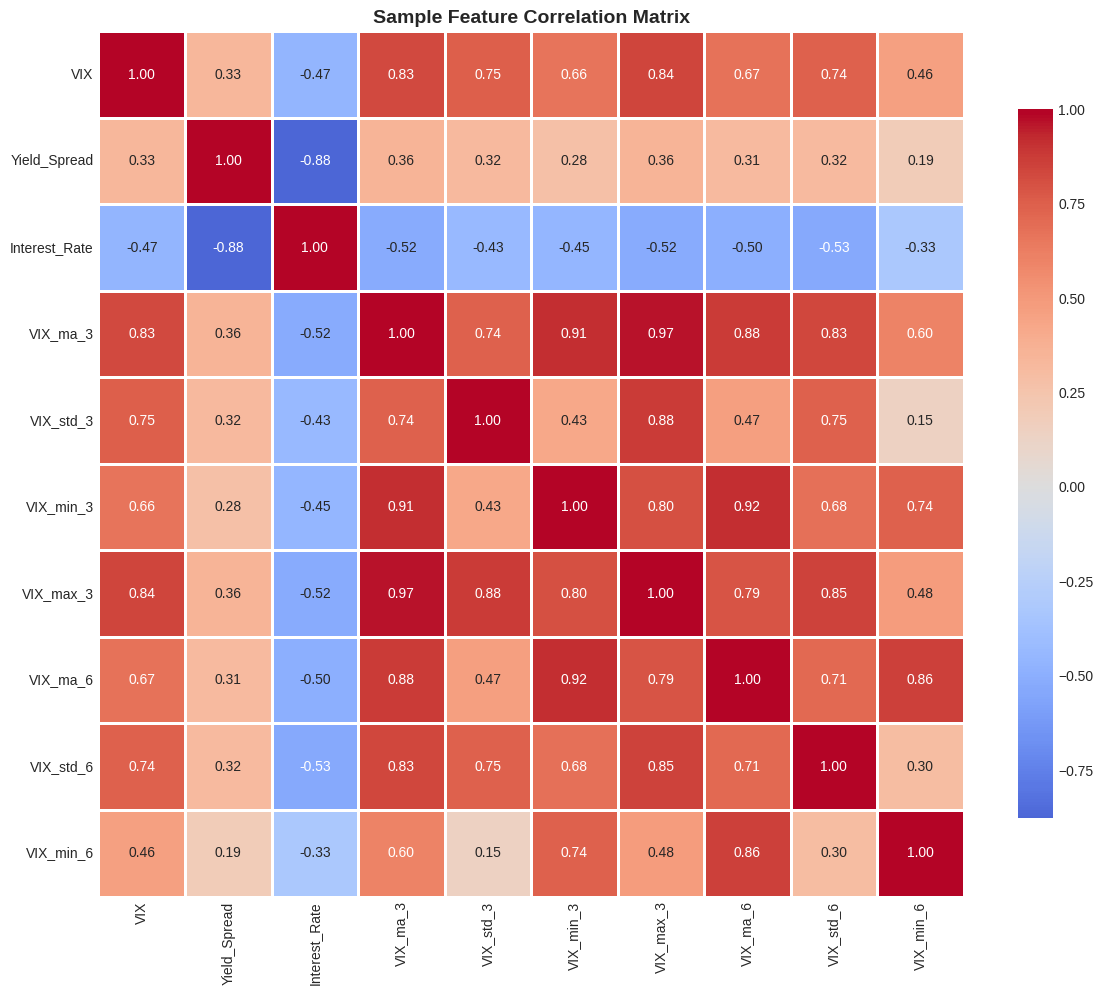

In [8]:
# Visualize feature correlations (sample)
sample_features = features[[col for col in features.columns if 'VIX' in col or 'Spread' in col or 'Rate' in col][:10]]

fig, ax = plt.subplots(figsize=(12, 10))
corr = sample_features.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, ax=ax, cbar_kws={'shrink': 0.8})
ax.set_title('Sample Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Prepare Training Data

In [9]:
# Initialize ML model
ml_model = PortfolioMLModel(config)

# Create target variables (next period returns)
targets = ml_model.create_target_variables(returns, lookback=1)

print(f"Targets created: {targets.shape}")
print(f"\nTarget assets: {list(targets.columns)}")

Targets created: (95, 4)

Target assets: ['BTC-USD', 'GLD', 'SPY', 'TLT']


In [10]:
# Train/test split
X_train, X_test, y_train, y_test = ml_model.prepare_train_test_data(
    features, 
    targets,
    test_size=config['model']['validation']['test_size']
)

print(f"Training set: {X_train.shape}")
print(f"  From {X_train.index[0]} to {X_train.index[-1]}")
print(f"\nTest set: {X_test.shape}")
print(f"  From {X_test.index[0]} to {X_test.index[-1]}")

print(f"\nTrain/Test split: {len(X_train)}/{len(X_test)} ({len(X_train)/(len(X_train)+len(X_test)):.1%}/{len(X_test)/(len(X_train)+len(X_test)):.1%})")

Training set: (67, 67)
  From 2017-12-31 00:00:00 to 2023-06-30 00:00:00

Test set: (17, 67)
  From 2023-07-31 00:00:00 to 2024-11-30 00:00:00

Train/Test split: 67/17 (79.8%/20.2%)


## 4. Train Models

In [11]:
# Train models for all assets
models = ml_model.train_all_models(X_train, y_train)

print(f"\nTrained {len(models)} models")
print(f"Model type: {type(list(models.values())[0]).__name__}")
print(f"Model parameters: {ml_model.model_params}")



Training Models for All Assets
Training model for BTC-USD...
  Training MSE: 0.000614
  Training R²: 0.4380
Training model for GLD...
  Training MSE: 0.000026
  Training R²: 0.5475
Training model for SPY...
  Training MSE: 0.000032
  Training R²: 0.5687
Training model for TLT...
  Training MSE: 0.000017
  Training R²: 0.6697

Trained 4 models successfully!

Trained 4 models
Model type: DecisionTreeRegressor
Model parameters: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 5, 'random_state': 42}


In [12]:
# Display training history
print("Training performance:")
training_df = pd.DataFrame(ml_model.training_history).T
display(training_df)

Training performance:


,train_mse,train_r2
BTC-USD,6.1409e-04,0.4380
GLD,2.5893e-05,0.5475
SPY,3.2394e-05,0.5687
TLT,1.6782e-05,0.6697


## 5. Evaluate Models

In [13]:
# Evaluate on test set
evaluation_results = ml_model.evaluate_all_models(X_test, y_test)

print("\nDetailed evaluation results:")
display(evaluation_results)


Evaluating Models on Test Set

BTC-USD:
  RMSE: 0.024499
  MAE: 0.019194
  R²: -0.2990
  Directional Accuracy: 76.47%

GLD:
  RMSE: 0.011035
  MAE: 0.008052
  R²: -0.9696
  Directional Accuracy: 35.29%

SPY:
  RMSE: 0.013061
  MAE: 0.009947
  R²: -1.0170
  Directional Accuracy: 41.18%

TLT:
  RMSE: 0.008430
  MAE: 0.006299
  R²: -0.9565
  Directional Accuracy: 41.18%

Evaluation Complete!

Detailed evaluation results:


,mse,rmse,mae,r2,directional_accuracy
BTC-USD,6.0021e-04,0.0245,0.0192,-0.2990,0.7647
GLD,1.2177e-04,0.0110,0.0081,-0.9696,0.3529
SPY,1.7060e-04,0.0131,0.0099,-1.0170,0.4118
TLT,7.1065e-05,0.0084,0.0063,-0.9565,0.4118


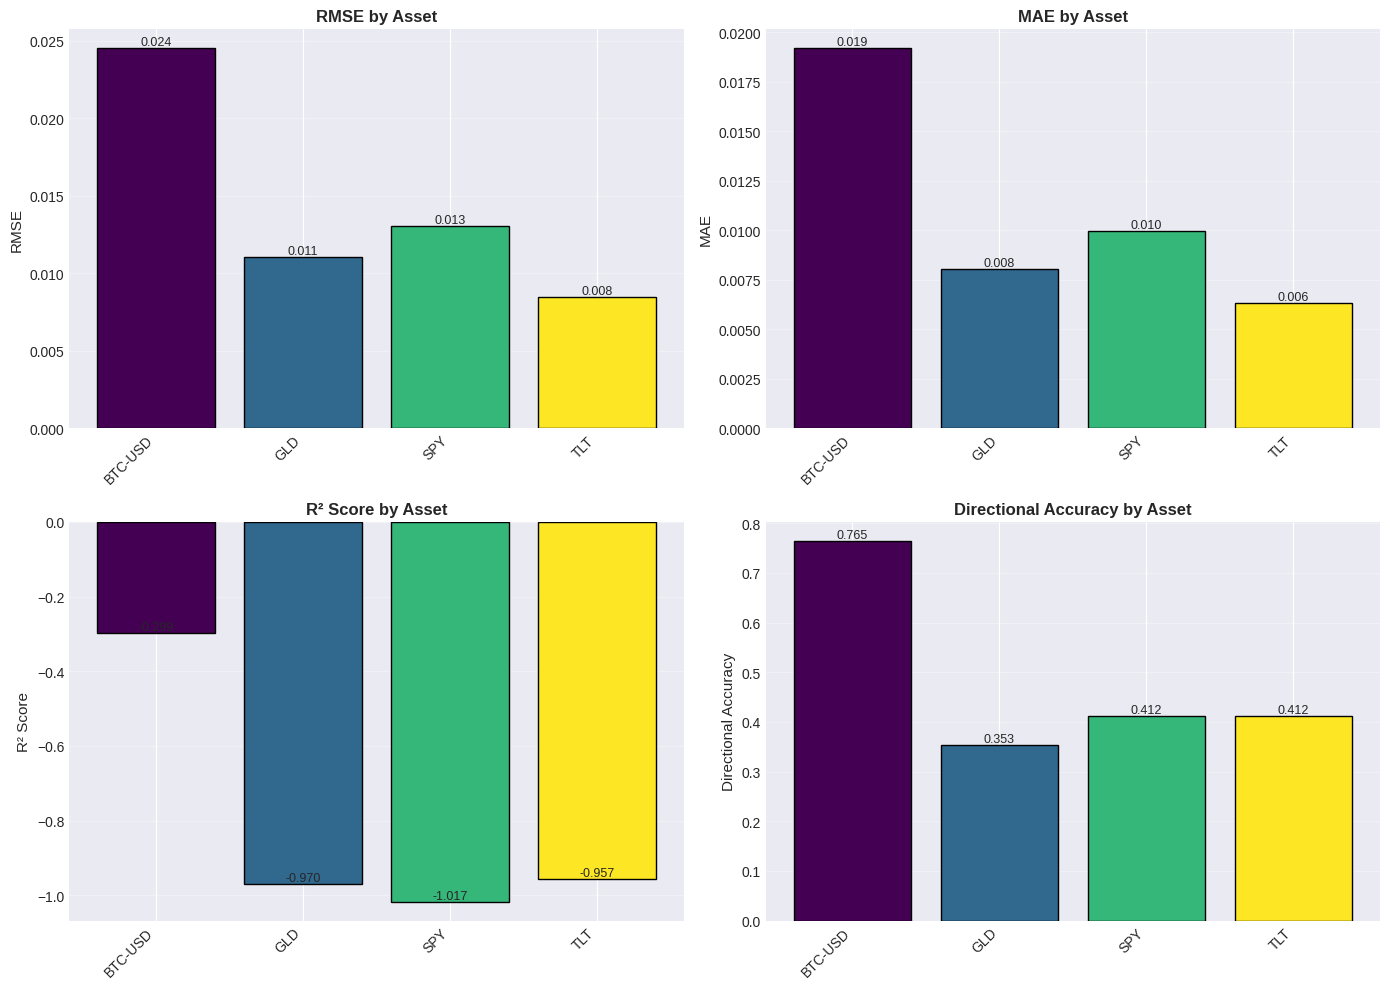

In [14]:
# Visualize evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['rmse', 'mae', 'r2', 'directional_accuracy']
titles = ['RMSE', 'MAE', 'R² Score', 'Directional Accuracy']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[idx // 2, idx % 2]
    
    values = evaluation_results[metric]
    colors = plt.cm.viridis(np.linspace(0, 1, len(values)))
    
    bars = ax.bar(range(len(values)), values, color=colors, edgecolor='black')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(values.index, rotation=45, ha='right')
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title} by Asset', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

In [15]:
# Display feature importance for each asset
print("Top 15 features by importance:\n")

for asset, importance in ml_model.feature_importance.items():
    print(f"\n{asset}:")
    print(importance.head(15))

Top 15 features by importance:


BTC-USD:
Yield_Spread_change_3m         0.3407
Yield_Spread                   0.3042
Interest_Rate_std_12           0.1844
Interest_Rate_ma_12            0.0608
VIX_change_6m                  0.0554
Interest_Rate_pct_change_3m    0.0352
VIX_ma_6                       0.0193
Interest_Rate                  0.0000
VIX                            0.0000
VIX_min_3                      0.0000
VIX_ma_3                       0.0000
VIX_ma_12                      0.0000
VIX_std_12                     0.0000
VIX_min_12                     0.0000
VIX_std_3                      0.0000
dtype: float64

GLD:
VIX                            0.4536
VIX_std_3                      0.1463
VIX_ma_3                       0.1333
Interest_Rate_std_6            0.0952
Interest_Rate_pct_change_6m    0.0835
Interest_Rate_std_12           0.0455
Yield_Spread_change_1m         0.0426
Interest_Rate                  0.0000
Yield_Spread                   0.0000
VIX_ma_6                 

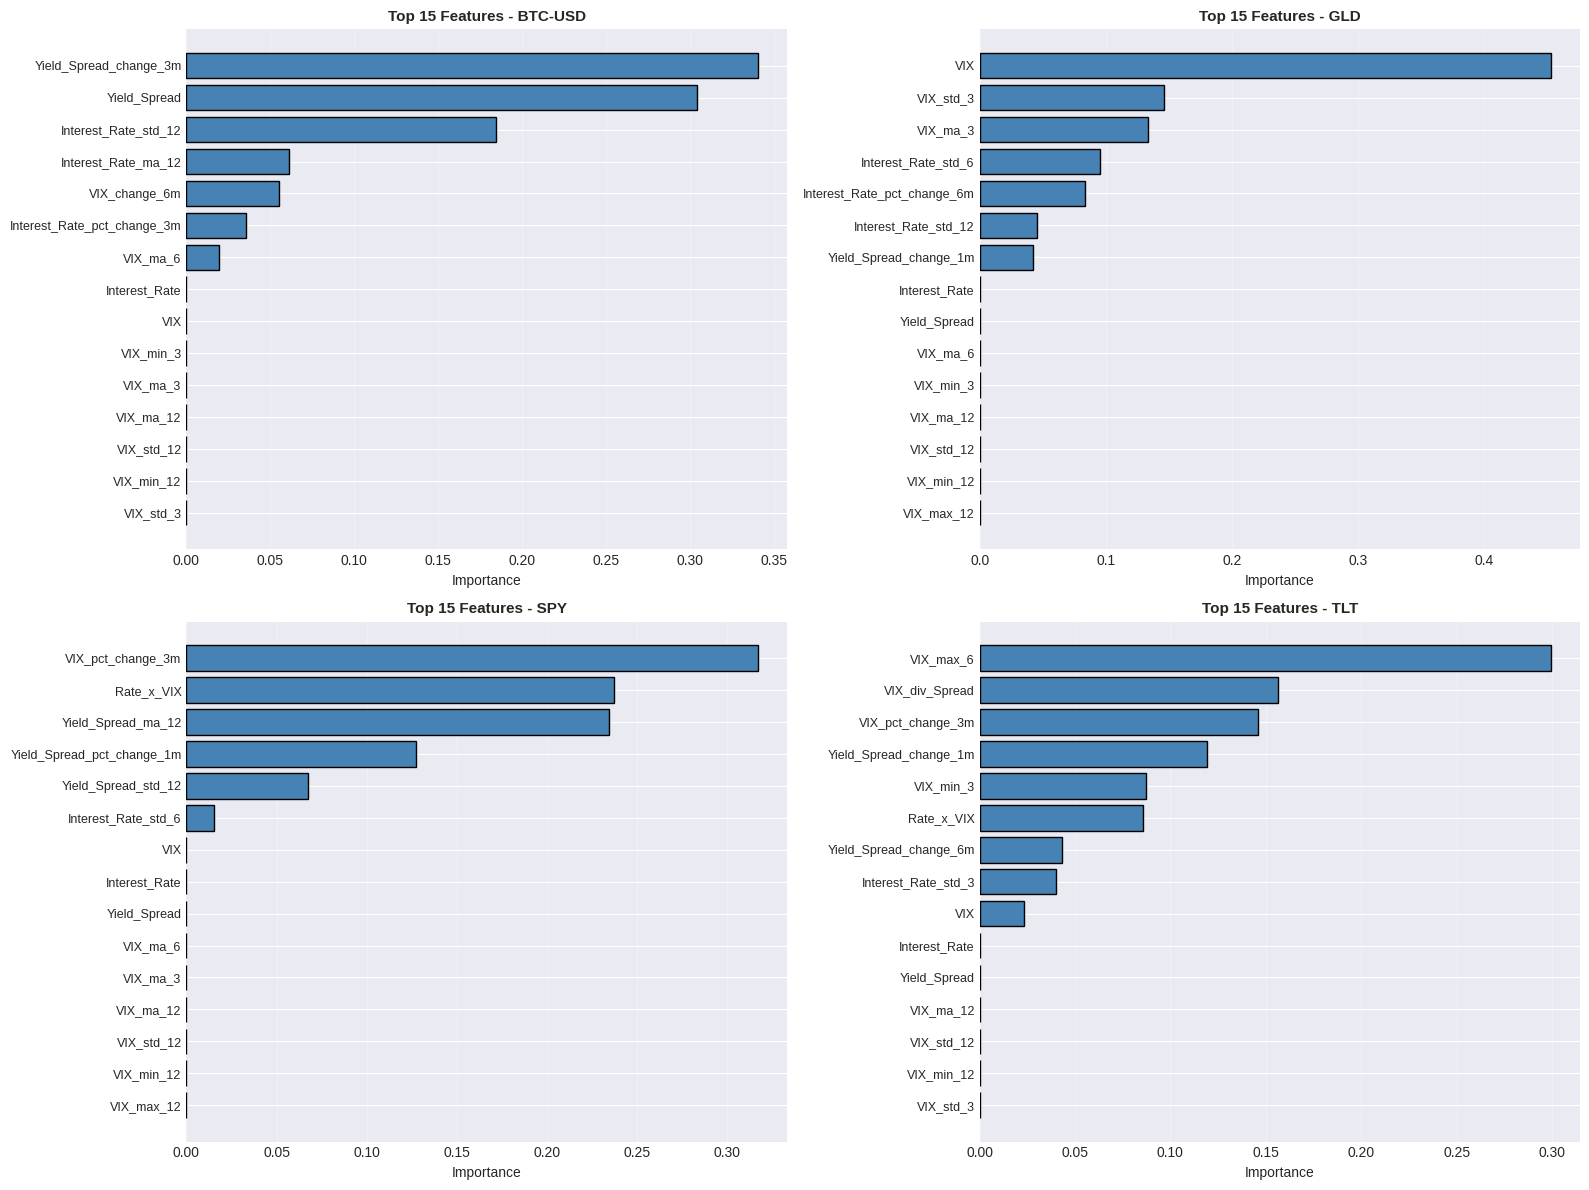

In [16]:
# Visualize feature importance for all assets
n_assets = len(ml_model.feature_importance)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (asset, importance) in enumerate(ml_model.feature_importance.items()):
    if idx < len(axes):
        top_features = importance.head(15)
        
        axes[idx].barh(range(len(top_features)), top_features.values, color='steelblue', edgecolor='black')
        axes[idx].set_yticks(range(len(top_features)))
        axes[idx].set_yticklabels(top_features.index, fontsize=9)
        axes[idx].set_xlabel('Importance', fontsize=10)
        axes[idx].set_title(f'Top 15 Features - {asset}', fontsize=11, fontweight='bold')
        axes[idx].grid(True, alpha=0.3, axis='x')
        axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

Average feature importance across all assets:
VIX                            0.1192
VIX_pct_change_3m              0.1158
Yield_Spread_change_3m         0.0852
Rate_x_VIX                     0.0807
Yield_Spread                   0.0761
VIX_max_6                      0.0749
Yield_Spread_ma_12             0.0587
Interest_Rate_std_12           0.0575
Yield_Spread_change_1m         0.0405
VIX_div_Spread                 0.0391
VIX_std_3                      0.0366
VIX_ma_3                       0.0333
Yield_Spread_pct_change_1m     0.0319
Interest_Rate_std_6            0.0276
VIX_min_3                      0.0218
Interest_Rate_pct_change_6m    0.0209
Yield_Spread_std_12            0.0169
Interest_Rate_ma_12            0.0152
VIX_change_6m                  0.0138
Yield_Spread_change_6m         0.0108
dtype: float64


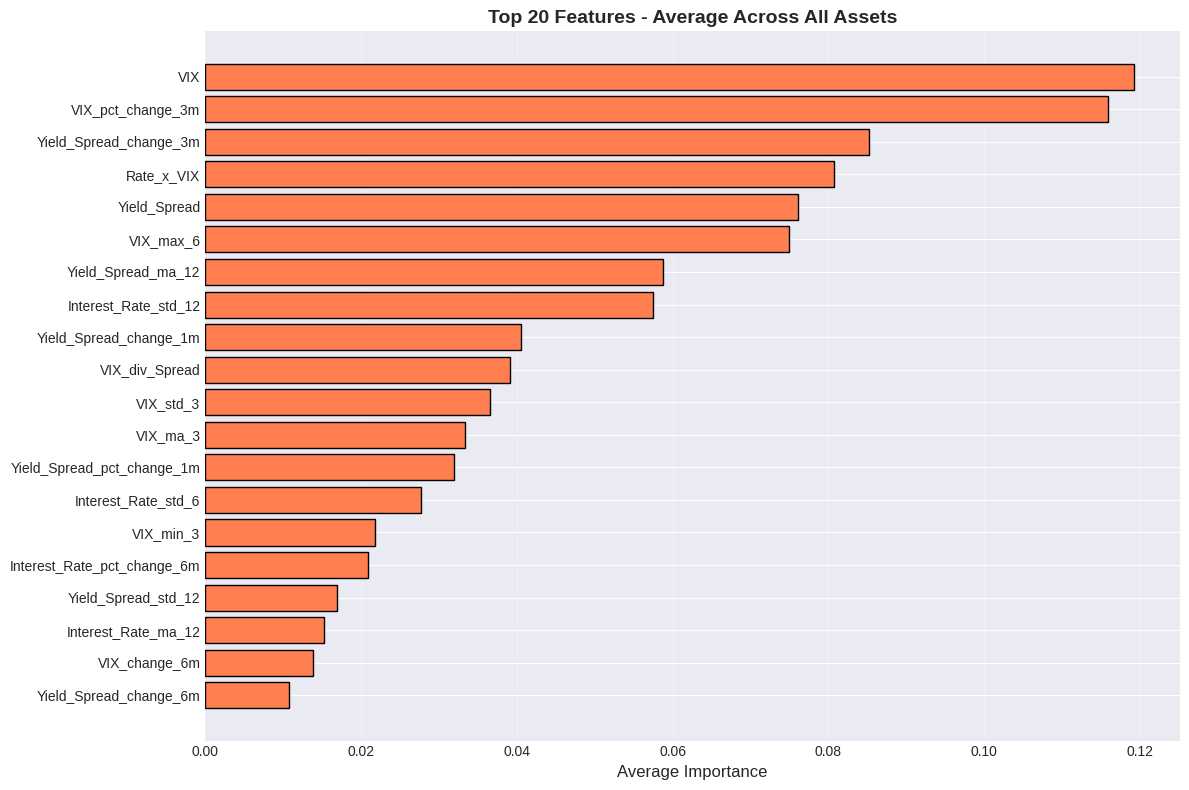

In [17]:
# Aggregate feature importance across all assets
all_importance = pd.DataFrame(ml_model.feature_importance)
avg_importance = all_importance.mean(axis=1).sort_values(ascending=False)

print("Average feature importance across all assets:")
print(avg_importance.head(20))

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
top_avg = avg_importance.head(20)
ax.barh(range(len(top_avg)), top_avg.values, color='coral', edgecolor='black')
ax.set_yticks(range(len(top_avg)))
ax.set_yticklabels(top_avg.index, fontsize=10)
ax.set_xlabel('Average Importance', fontsize=12)
ax.set_title('Top 20 Features - Average Across All Assets', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Prediction Analysis

In [18]:
# Make predictions on test set
predictions = ml_model.predict_returns(X_test)

print("Predictions shape:", predictions.shape)
print("\nSample predictions:")
display(predictions.head(10))

Predictions shape: (17, 4)

Sample predictions:


,BTC-USD,GLD,SPY,TLT
2023-07-31,0.0091,-0.0008,-0.0096,0.0092
2023-08-31,0.0091,-0.0018,-0.0011,0.0018
2023-09-30,0.0091,-0.0008,0.0087,0.0108
2023-10-31,-0.0186,-0.0008,0.0087,0.0108
2023-11-30,-0.0186,-0.0008,-0.0096,0.0018
2023-12-31,-0.0254,0.0047,0.0095,0.0092
2024-01-31,-0.0254,0.0077,-0.0096,0.0018
2024-02-29,-0.0079,0.0077,-0.0096,0.0108
2024-03-31,-0.0079,0.0077,-0.0096,0.0018
2024-04-30,-0.0079,0.0077,0.0087,0.0108


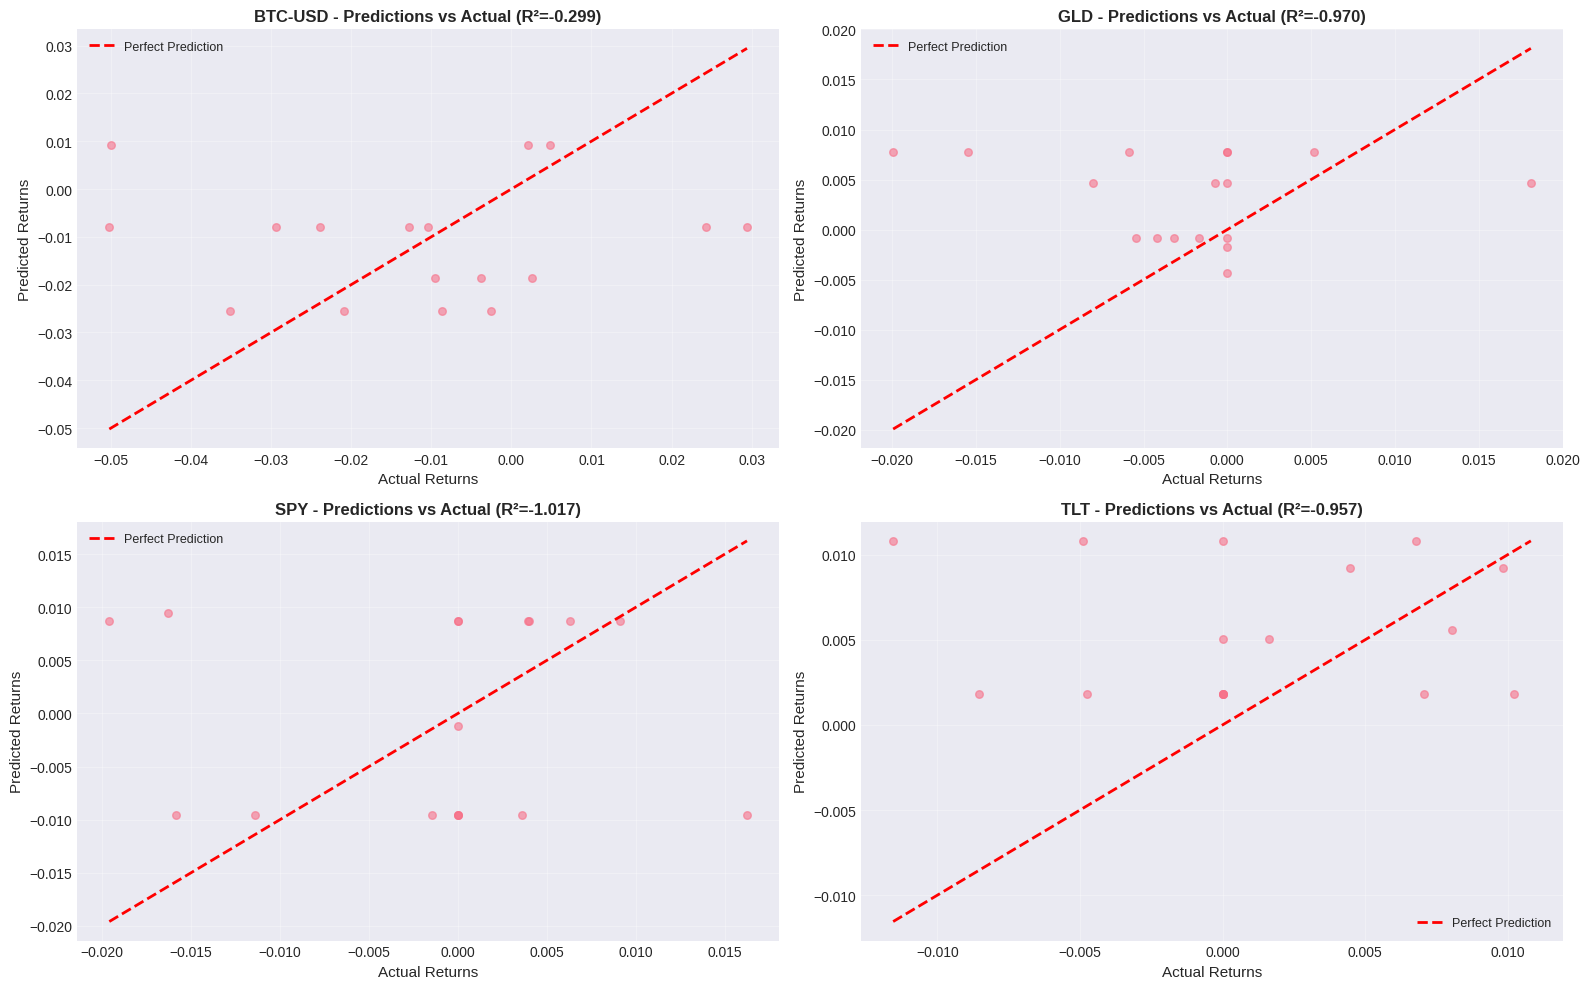

In [19]:
# Compare predictions vs actual returns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for idx, asset in enumerate(y_test.columns):
    if idx < len(axes):
        ax = axes[idx]
        
        # Scatter plot
        ax.scatter(y_test[asset], predictions[asset], alpha=0.6, s=30)
        
        # Add diagonal line (perfect prediction)
        min_val = min(y_test[asset].min(), predictions[asset].min())
        max_val = max(y_test[asset].max(), predictions[asset].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
        
        # Calculate R²
        from sklearn.metrics import r2_score
        r2 = r2_score(y_test[asset], predictions[asset])
        
        ax.set_xlabel('Actual Returns', fontsize=11)
        ax.set_ylabel('Predicted Returns', fontsize=11)
        ax.set_title(f'{asset} - Predictions vs Actual (R²={r2:.3f})', 
                    fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

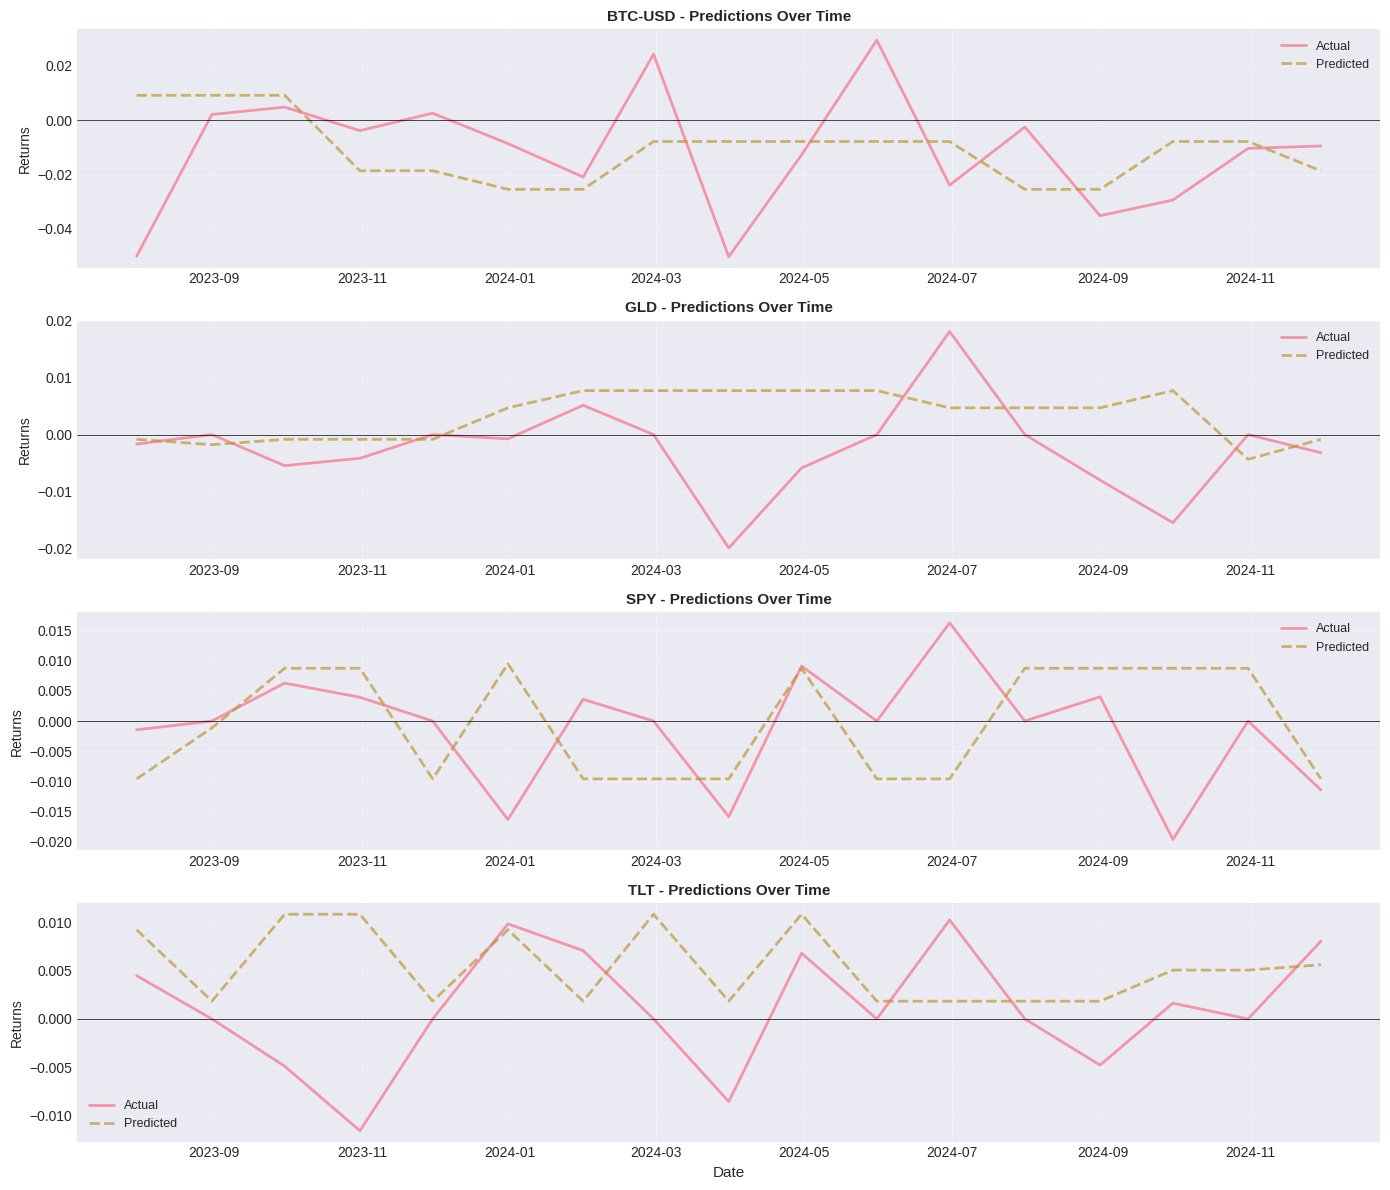

In [20]:
# Time series of predictions vs actuals
fig, axes = plt.subplots(len(y_test.columns), 1, figsize=(14, 12))

for idx, asset in enumerate(y_test.columns):
    axes[idx].plot(y_test.index, y_test[asset], label='Actual', linewidth=2, alpha=0.7)
    axes[idx].plot(predictions.index, predictions[asset], label='Predicted', 
                  linewidth=2, alpha=0.7, linestyle='--')
    axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[idx].set_ylabel('Returns', fontsize=10)
    axes[idx].set_title(f'{asset} - Predictions Over Time', fontsize=11, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date', fontsize=11)
plt.tight_layout()
plt.show()

## 8. Cross-Validation

In [21]:
# Perform time series cross-validation
print("Performing cross-validation...")
cv_scores = ml_model.cross_validate(
    X_train, 
    y_train, 
    cv=config['model']['validation']['cv_folds']
)

print("\nCross-validation results:")
cv_df = pd.DataFrame(cv_scores).T
display(cv_df)

Performing cross-validation...

Cross-validation results:


,mean_mse,std_mse
BTC-USD,1.4205e-03,8.1188e-04
GLD,8.8808e-05,1.8159e-05
SPY,9.2646e-05,4.4617e-05
TLT,6.8372e-05,4.1218e-05


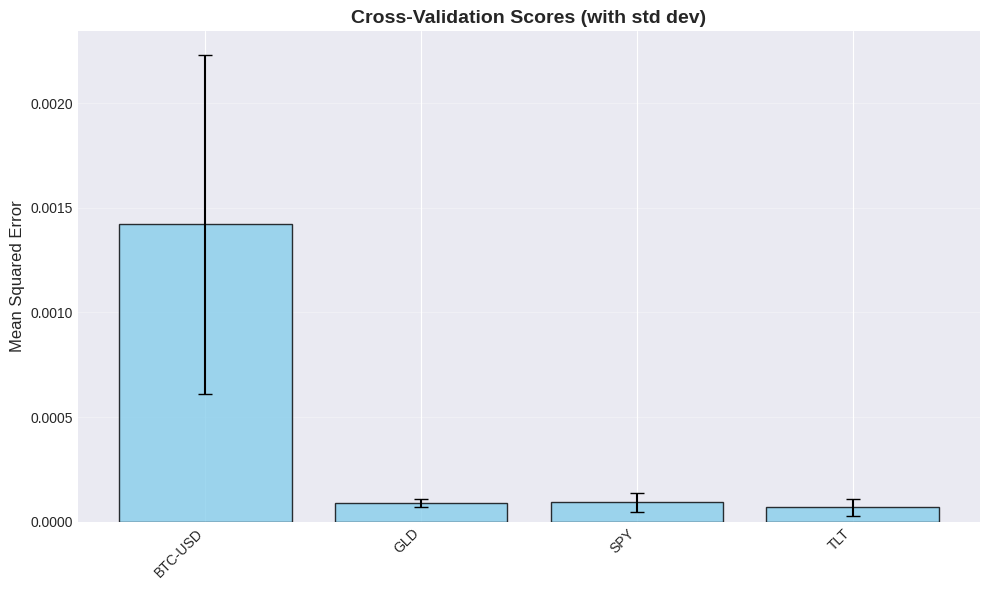

In [22]:
# Visualize CV scores
fig, ax = plt.subplots(figsize=(10, 6))

assets = list(cv_scores.keys())
means = [cv_scores[asset]['mean_mse'] for asset in assets]
stds = [cv_scores[asset]['std_mse'] for asset in assets]

x_pos = np.arange(len(assets))
ax.bar(x_pos, means, yerr=stds, capsize=5, color='skyblue', edgecolor='black', alpha=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(assets, rotation=45, ha='right')
ax.set_ylabel('Mean Squared Error', fontsize=12)
ax.set_title('Cross-Validation Scores (with std dev)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 9. Model Visualization (Sample)

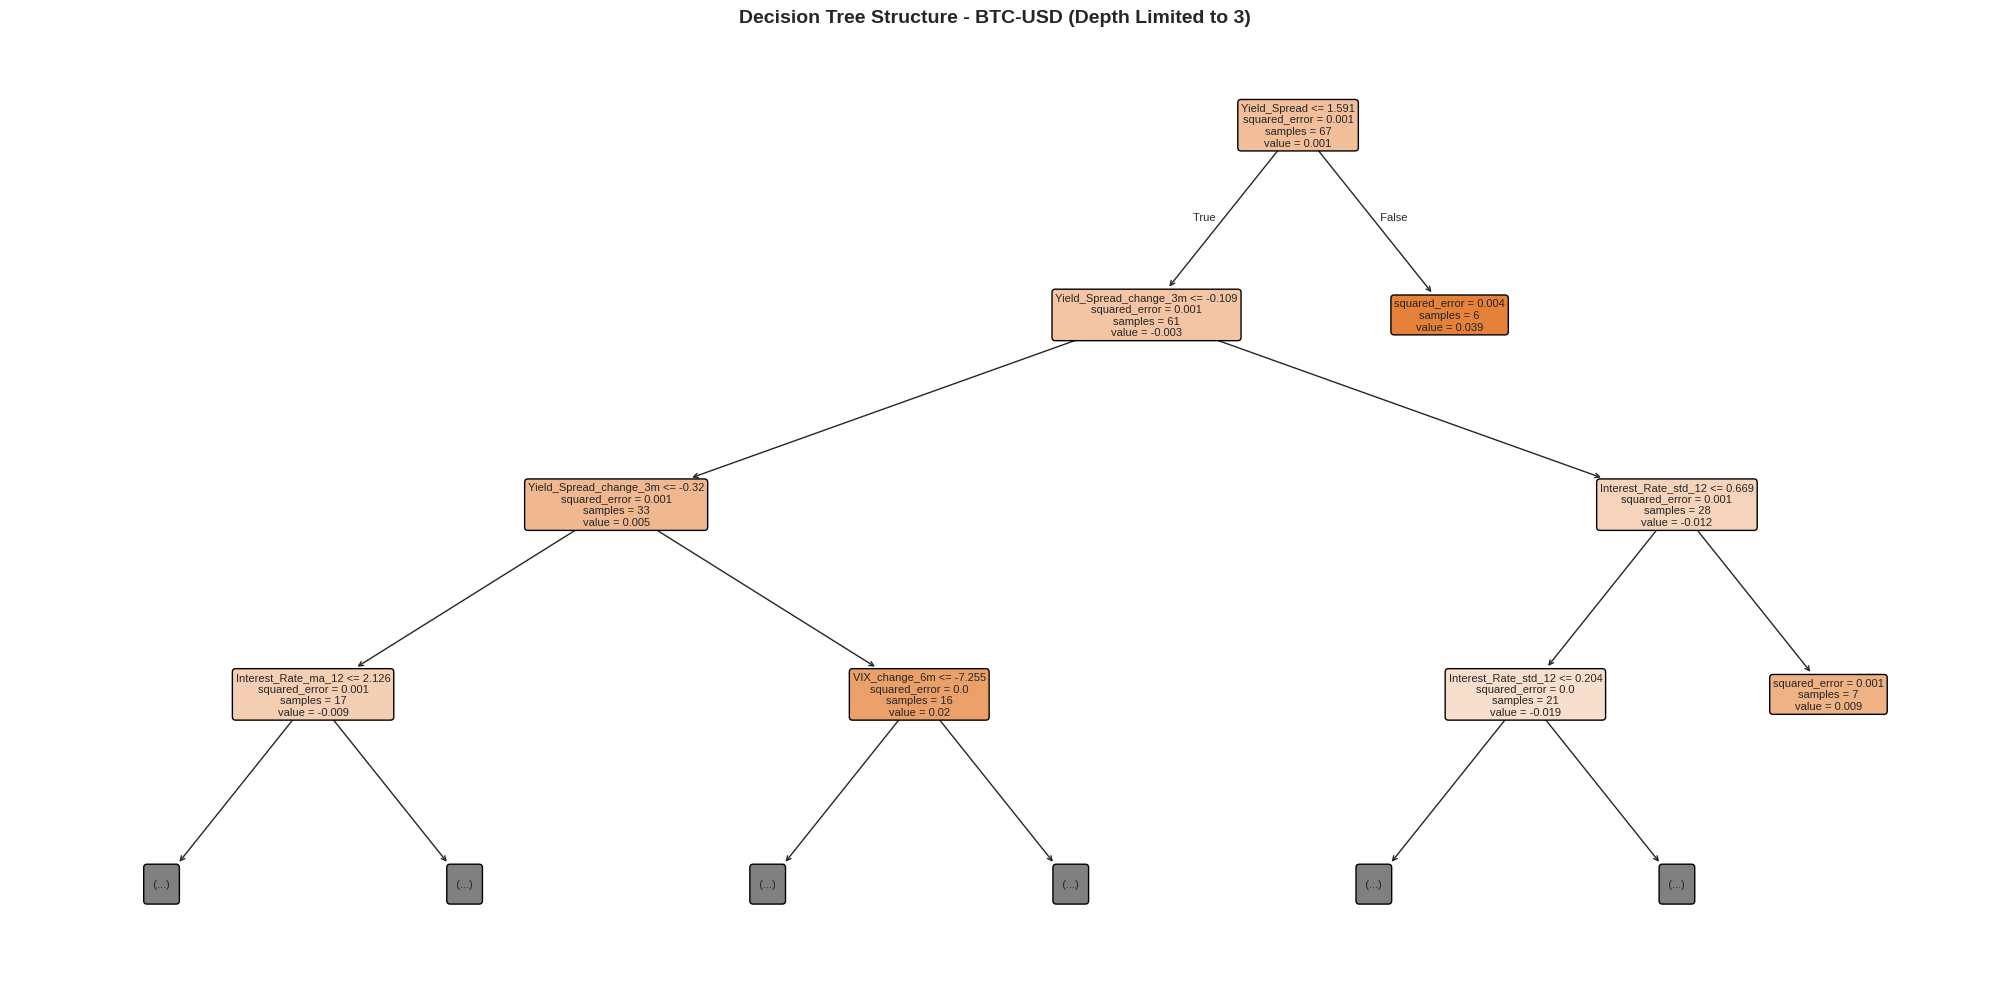

Note: Full tree has depth 5
Number of leaves: 11


In [23]:
# Visualize decision tree structure for one asset (limited depth for readability)
sample_asset = list(models.keys())[0]
sample_model = models[sample_asset]

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(sample_model, 
          feature_names=X_train.columns,
          filled=True,
          rounded=True,
          fontsize=8,
          max_depth=3,  # Limit depth for visualization
          ax=ax)
ax.set_title(f'Decision Tree Structure - {sample_asset} (Depth Limited to 3)', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Note: Full tree has depth {sample_model.get_depth()}")
print(f"Number of leaves: {sample_model.get_n_leaves()}")

In [ ]:
# Save models
ml_model.save_models(config['output']['models_dir'])
print(f"Models saved to {config['output']['models_dir']}/")
